# Plynomial_Regression

+ Uni and Bivariant Data analysis 
+ work only with nummerical values:
  - Handle outliers
  - Explore the distributions
  - impute missing values
  - Different multivariable linear models created with Statsmodels and Sklearn
  - Compare the results with polynominal model
+ Categorical Values:
  - One-Way Anova test

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import math
from scipy import stats 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure

In [2]:
# load train part  
df=pd.read_csv('./Data/Hackathon/train.csv')

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Flight_ID           45000 non-null  object 
 1   Airline             41427 non-null  object 
 2   Departure_City      44660 non-null  object 
 3   Arrival_City        44814 non-null  object 
 4   Distance            44909 non-null  float64
 5   Departure_Time      45000 non-null  object 
 6   Arrival_Time        45000 non-null  object 
 7   Duration            45000 non-null  float64
 8   Aircraft_Type       44957 non-null  object 
 9   Number_of_Stops     45000 non-null  int64  
 10  Day_of_Week         44775 non-null  object 
 11  Month_of_Travel     44733 non-null  object 
 12  Holiday_Season      35980 non-null  object 
 13  Demand              44683 non-null  object 
 14  Weather_Conditions  44698 non-null  object 
 15  Passenger_Count     45000 non-null  int64  
 16  Prom

In [4]:
Numerical_columns=df.select_dtypes(exclude='object').columns
Categorical_columns=df.select_dtypes(include='object').columns
print(Numerical_columns,len(Numerical_columns))
print(Categorical_columns,len(Categorical_columns))

Index(['Distance', 'Duration', 'Number_of_Stops', 'Passenger_Count',
       'Fuel_Price', 'Flight_Price'],
      dtype='object') 6
Index(['Flight_ID', 'Airline', 'Departure_City', 'Arrival_City',
       'Departure_Time', 'Arrival_Time', 'Aircraft_Type', 'Day_of_Week',
       'Month_of_Travel', 'Holiday_Season', 'Demand', 'Weather_Conditions',
       'Promotion_Type'],
      dtype='object') 13


## explore numerical columns

In [5]:
df[Numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Distance         44909 non-null  float64
 1   Duration         45000 non-null  float64
 2   Number_of_Stops  45000 non-null  int64  
 3   Passenger_Count  45000 non-null  int64  
 4   Fuel_Price       44910 non-null  float64
 5   Flight_Price     45000 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 2.1 MB


There are some null values in Distance and Fuel_Price columns !! 

In [6]:
df[Numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Distance,44909.0,5482.238727,2594.847860,1000.00,3230.0000,5476.00,7725.0000,10000.00
Duration,45000.0,7.852555,3.292880,1.28,5.0400,7.84,10.6500,14.45
Number_of_Stops,45000.0,0.665667,0.750578,0.00,0.0000,1.00,1.0000,3.00
Passenger_Count,45000.0,174.928822,72.372980,50.00,112.0000,175.00,238.0000,300.00
Fuel_Price,44910.0,0.850192,0.201736,0.50,0.6800,0.85,1.0200,1.20
Flight_Price,45000.0,574.606270,160.239344,173.35,455.2975,565.75,679.6925,1261.64


Points:
+ The Dependet Column is Flight Price
+ The values of column "Distance" overall are in a big range

<Axes: ylabel='Flight_Price'>

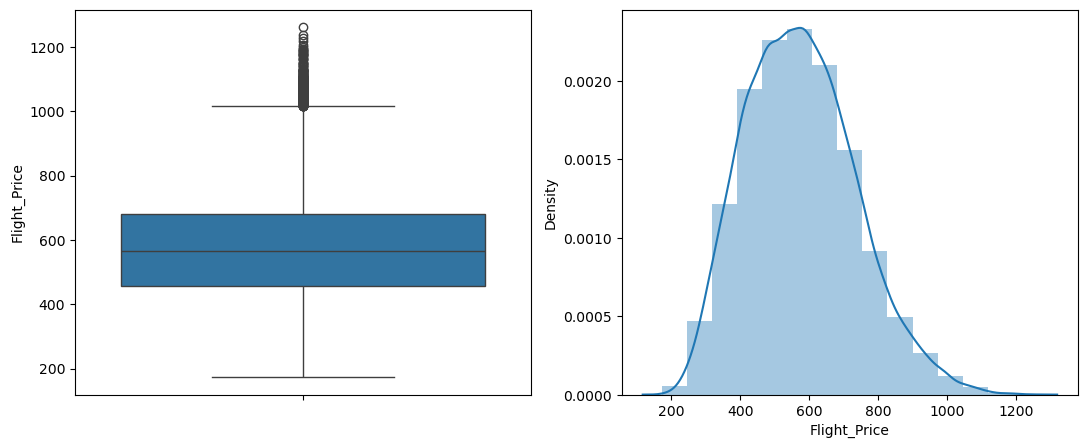

In [7]:
# distribution of Dependet Variable (Flight Price)
#DistPlot
f = plt.figure(figsize=(20,5))
boxplot= f.add_subplot(131)
dist = f.add_subplot(132)

sns.distplot(df.Flight_Price, bins = 15,ax=dist);
sns.boxplot(df.Flight_Price,ax=boxplot)


the distribution looks a little bit right skewed but ok ! 

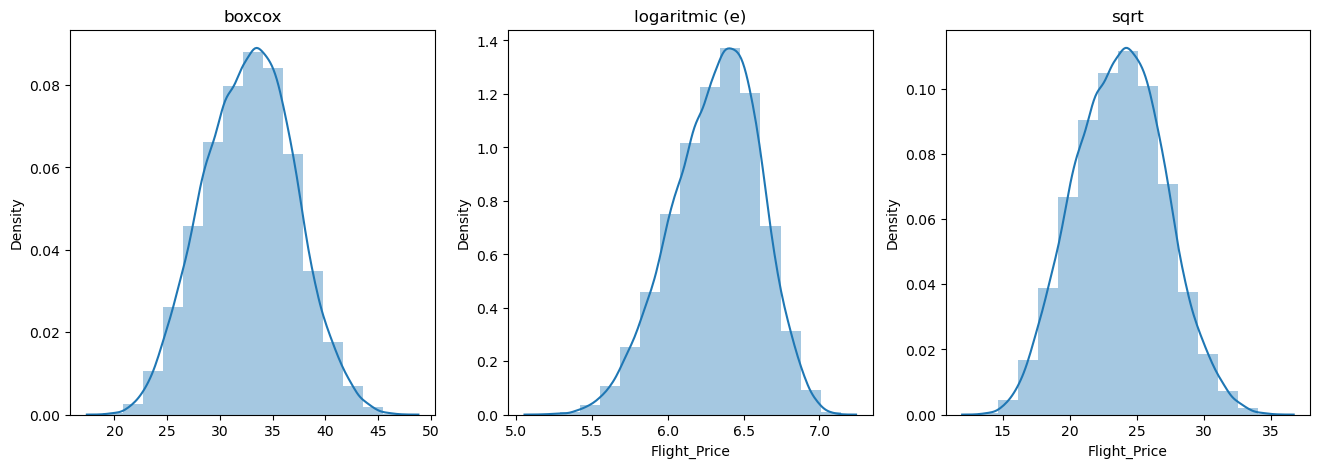

In [8]:
# Trying some other transformations
Y=df.Flight_Price
log_trafo=np.log(Y)
sqrt_trafo=np.sqrt(Y)
# we need to save the lambda parameter , so reverse the transformation for our predictions
box_trafo,lambda_box=stats.boxcox(Y)

f = plt.figure(figsize=(16,5))

box= f.add_subplot(131)
box.set_title('boxcox')
sns.distplot(box_trafo, bins = 15,ax=box);

log = f.add_subplot(132)
log.set_title('logaritmic (e)')
sns.distplot(log_trafo, bins = 15,ax=log);

sqrt=f.add_subplot(133)
sqrt.set_title('sqrt')

sns.distplot(sqrt_trafo, bins = 15,ax=sqrt);

plt.show()

the SQRT Transformation looks better than orginal and others! 

In [9]:
df['Flight_Price_Transformed']=sqrt_trafo
Numerical_columns=list(df.select_dtypes(exclude='object').columns)
Numerical_columns

['Distance',
 'Duration',
 'Number_of_Stops',
 'Passenger_Count',
 'Fuel_Price',
 'Flight_Price',
 'Flight_Price_Transformed']

## finding the outliers :
to define outliers we can:
- way one -> create boundries by looking along all values in each column (very generell )
- way two -> look for categorical value/values to create more specific boundries for outliers in every column</br>
A good Idea will be to define boundires with helf of "airline" column, as every airline has its specific </br>
route, prices,offers,...


In [10]:
#function for plotting violin plots
def plotting_box_violin_plots(df,x,y):
  fig,axes=plt.subplots(1,2,figsize=(20,5))
  fig.suptitle("Violin and box plots for variable : {}".format(y))

  sns.violinplot(ax=axes[0],x=x,y=y,data=df)
  sns.boxplot(ax=axes[1],data=df[y])

  axes[0].set_title("Violin plot for variable : {}".format(y))
  axes[1].set_title("Box plot for variable : {}".format(y))

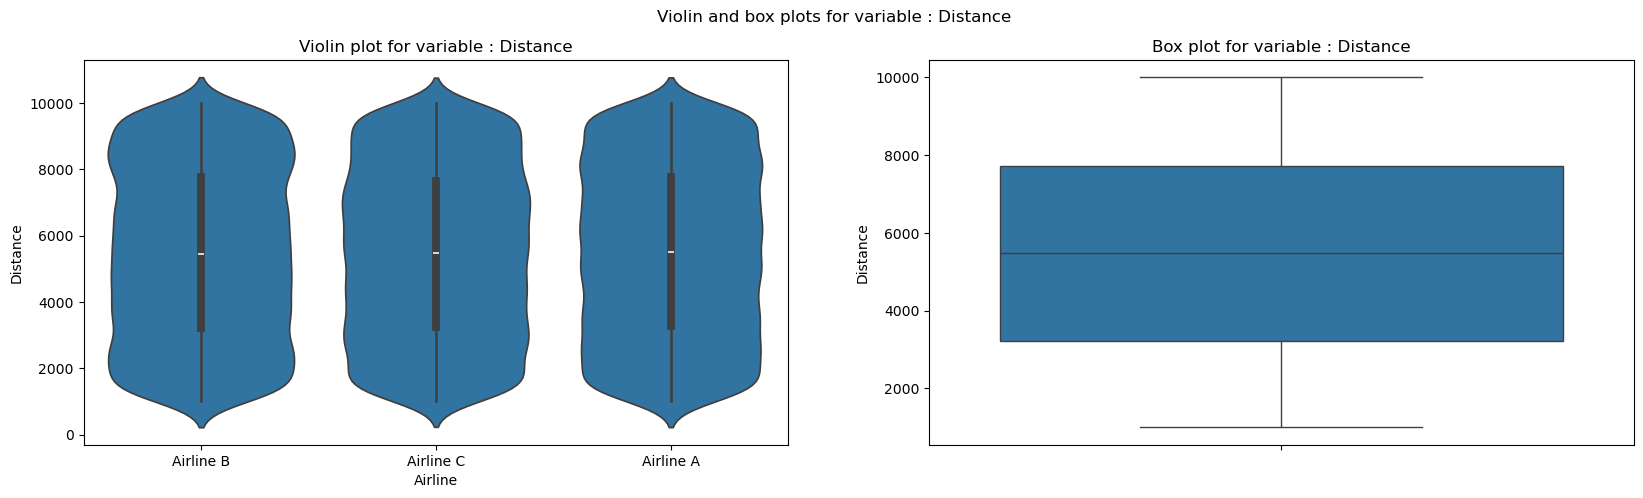

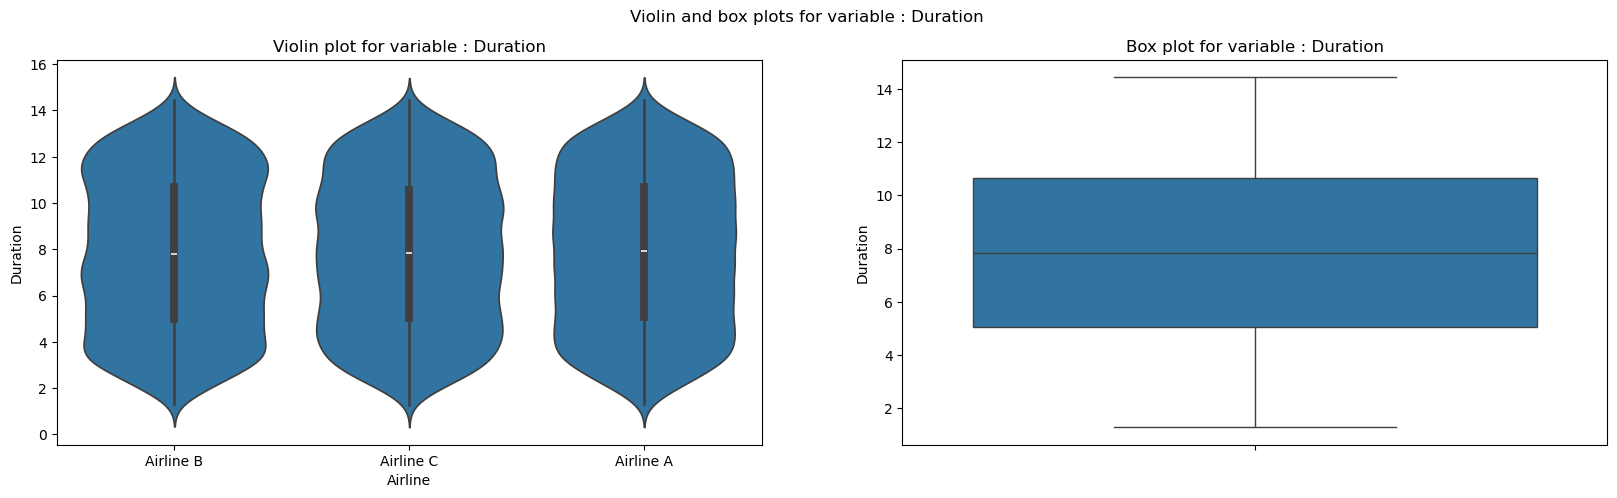

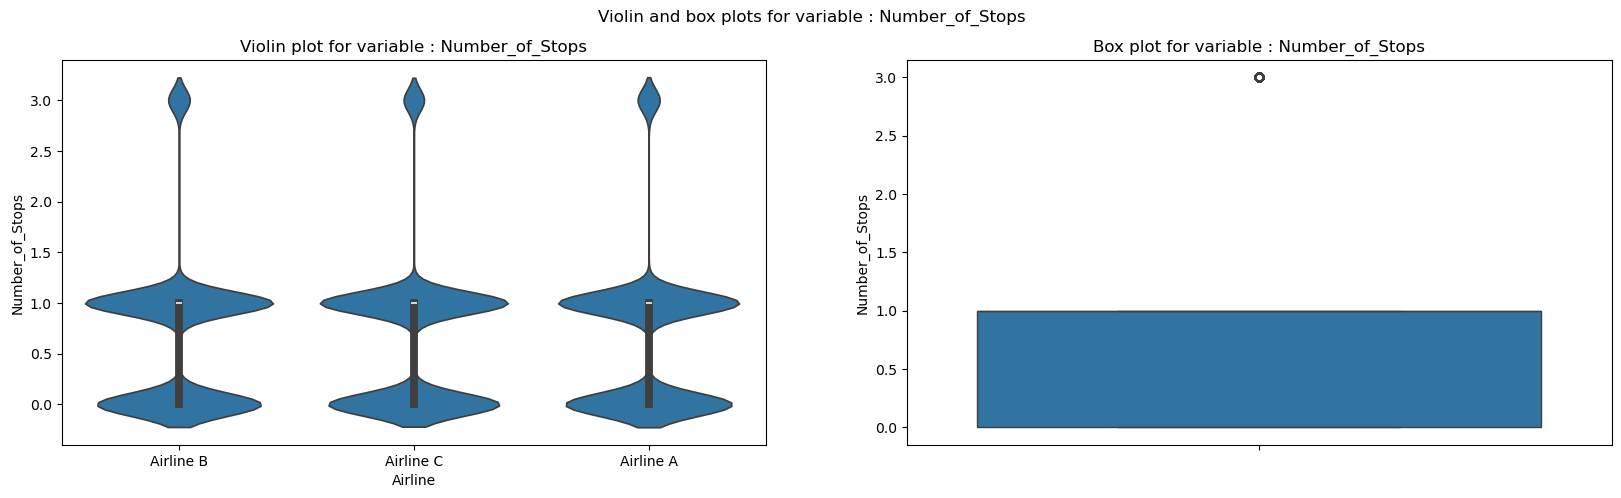

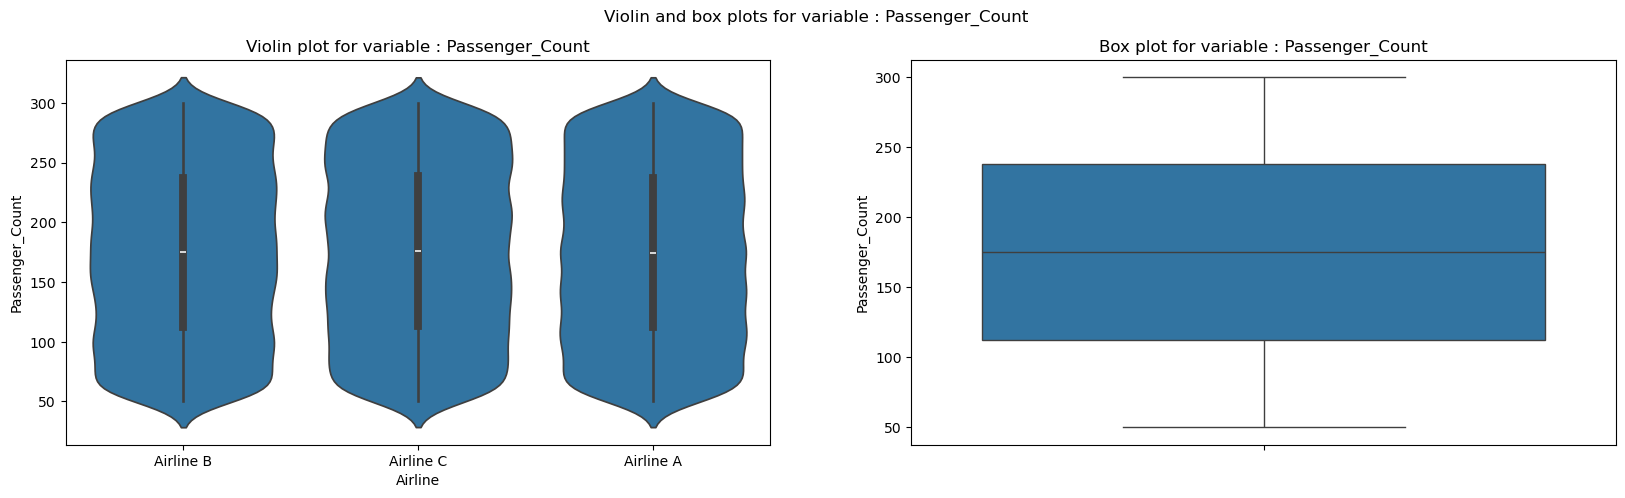

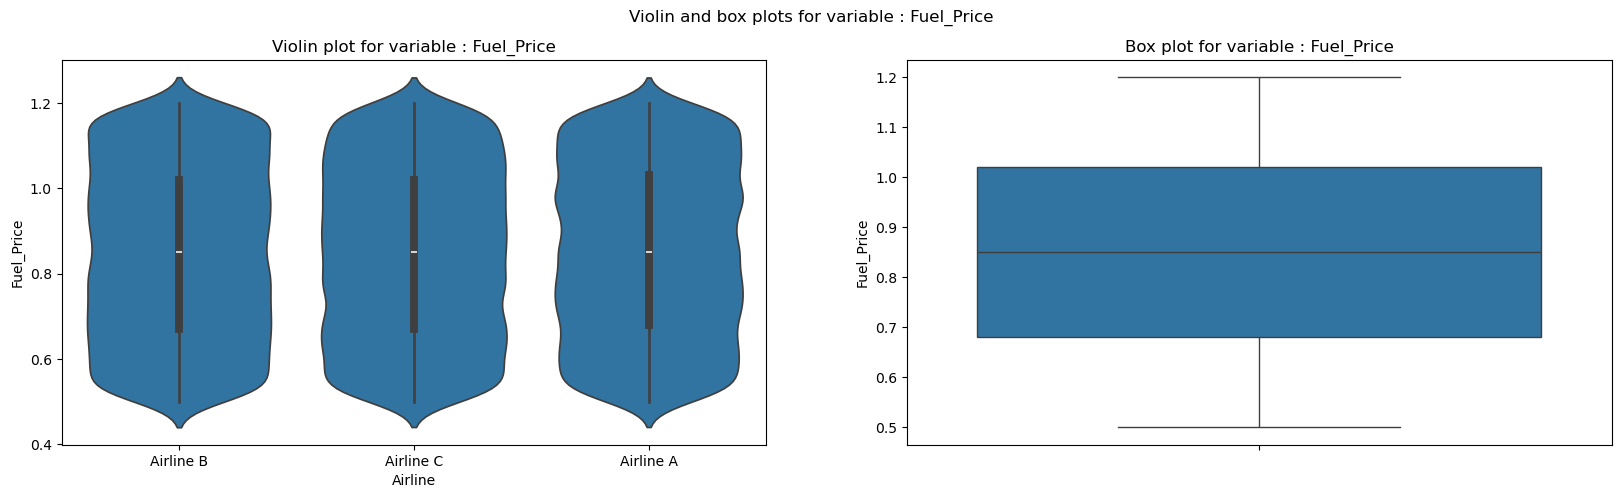

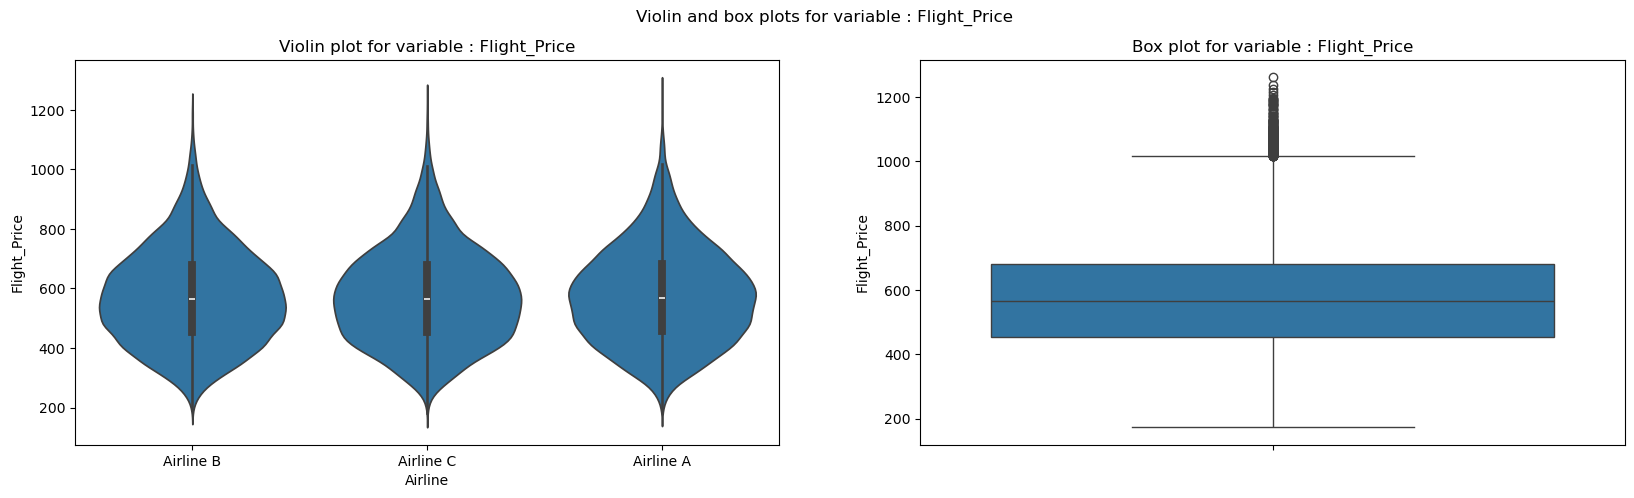

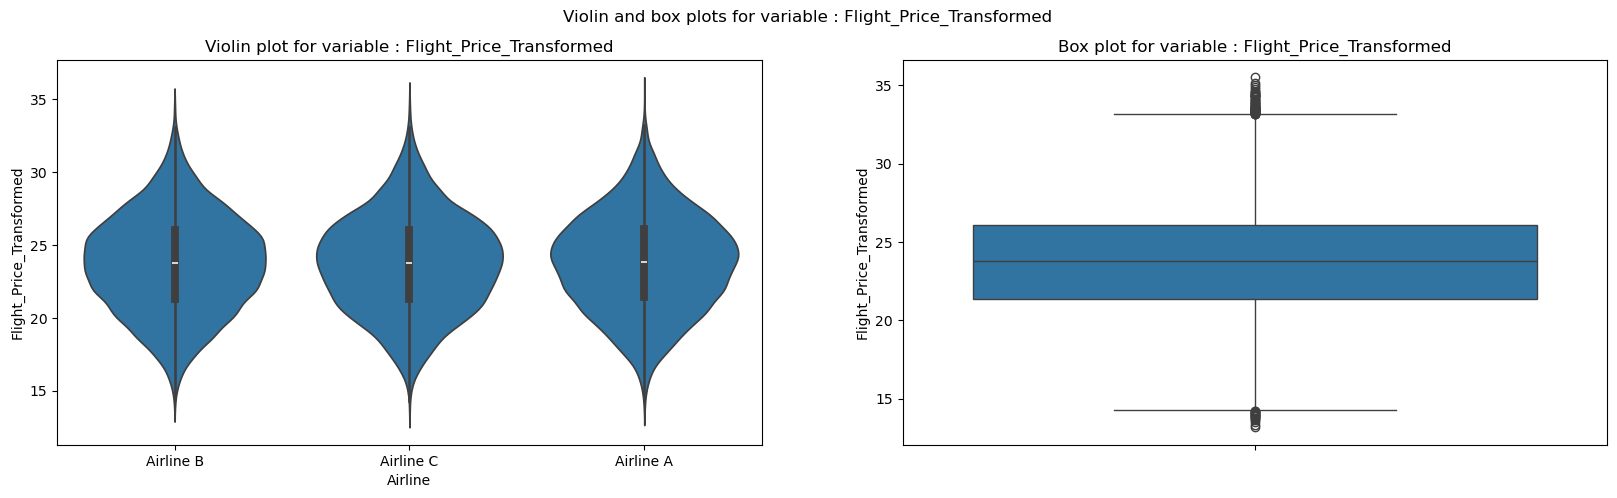

In [11]:
for col_name in Numerical_columns:
  plotting_box_violin_plots(df,"Airline",col_name)

As we see:
+ the distributions are definitly not normal along numric columns , only the "Flight_Price" has a normal form! </br>
+ The shapes of distributions , showed in violion plots, are simlilare , so we can look for some form of transformations</br>
for these columns!
+ "Flight_Price" has some outliers
+ "Number_of_Stops"-> sort of unbalaced population along all unique values (flys with 3 stops are rarly populated) 

#### finding Outliers


In [12]:
def find_outliers(df,column):
  Q1=df[column].quantile(0.25)
  Q3=df[column].quantile(0.75)
  IQR=Q3-Q1
  Upper_End=Q3+1.5*IQR
  Lower_End=Q1-1.5*IQR

  outlier=df[column][(df[column]>Upper_End)| (df[column]<Lower_End) ]

  return outlier

In [13]:
for col in Numerical_columns : 
    outliers=find_outliers(df,col)
    if not outliers.empty:
        print("for %s outliers are: "%col)
    
        print(outliers)
        print()

for Number_of_Stops outliers are: 
7        3
40       3
50       3
53       3
54       3
        ..
44943    3
44965    3
44968    3
44981    3
44993    3
Name: Number_of_Stops, Length: 2556, dtype: int64

for Flight_Price outliers are: 
62       1058.69
137      1029.38
847      1028.73
922      1119.96
945      1115.61
          ...   
44136    1044.46
44509    1038.26
44521    1117.78
44726    1034.76
44898    1019.47
Name: Flight_Price, Length: 289, dtype: float64

for Flight_Price_Transformed outliers are: 
922      33.465803
945      33.400748
1188     34.553582
1377     33.205722
1791     14.084389
           ...    
42526    34.620081
43818    33.223937
44301    13.633048
44506    13.703649
44521    33.433217
Name: Flight_Price_Transformed, Length: 86, dtype: float64



In [14]:
prices_outliers=find_outliers(df,"Flight_Price")
print("len of dataset: ",len(df))
print(f' the dropped percentage will be {len(prices_outliers)/len(df)*100} % of Dataset')

len of dataset:  45000
 the dropped percentage will be 0.6422222222222222 % of Dataset


In [15]:
#Ok, this is even less than 1 % of the dataset, we will drop it ! 
df_v1=df.drop(prices_outliers.index)
print("len of new dataset: ",len(df_v1))

len of new dataset:  44711


### Impute value for Nans in "Distance" and "Fuel_Price"

In [16]:
df_v1[Numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 44711 entries, 0 to 44999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Distance                  44621 non-null  float64
 1   Duration                  44711 non-null  float64
 2   Number_of_Stops           44711 non-null  int64  
 3   Passenger_Count           44711 non-null  int64  
 4   Fuel_Price                44623 non-null  float64
 5   Flight_Price              44711 non-null  float64
 6   Flight_Price_Transformed  44711 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


<Axes: title={'center': 'Nr of missing values across each column'}>

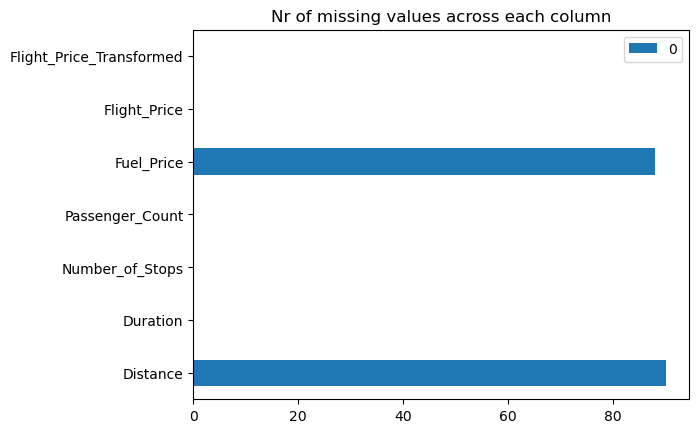

In [17]:
ncounts=pd.DataFrame([df_v1[Numerical_columns].isna().sum()]).T
ncounts=ncounts.rename(columns={1:'data_missing'})
ncounts.plot(kind='barh',title='Nr of missing values across each column')

In [18]:
# To choose the best imputer from skelearn , i will try different ones and train a simple linear regression model ! 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.pipeline import Pipeline
#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#
from sklearn.impute import SimpleImputer
#
from sklearn.impute import KNNImputer

In [19]:
independet_cols= [col_name for col_name in Numerical_columns if col_name not in ['Flight_Price','Flight_Price_Transformed']]
independet_cols

['Distance', 'Duration', 'Number_of_Stops', 'Passenger_Count', 'Fuel_Price']

In [20]:
# using Skilearn Imputer
#model
model=LinearRegression()
# define different imputers
imputer_iter=IterativeImputer(max_iter=10)
imputer_simple=SimpleImputer(strategy='mean')
imputer_KNN=KNNImputer(n_neighbors=3)
# list of them to use in loop
imputer_list=[imputer_iter,imputer_simple,imputer_KNN]
# loop for evaluate differen imputers
X=df_v1[independet_cols]
y=df_v1['Flight_Price']
for imputer in imputer_list:
    pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
    cv=KFold(n_splits=5, random_state=693, shuffle=True)
    scores = cross_val_score(pipeline, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    #print(scores)
    print(f'Mean loss for imputer: {str(imputer)} is {-1*scores.mean():.3f} std {scores.std():.3f}')

Mean loss for imputer: IterativeImputer() is 77.357 std 1.025
Mean loss for imputer: SimpleImputer() is 77.424 std 1.026
Mean loss for imputer: KNNImputer(n_neighbors=3) is 77.388 std 1.020


Iterative imputer performs better than other ! 

In [21]:
# now we use all columns to impute the missing data
df_v2=imputer_iter.fit_transform(df_v1[Numerical_columns])
df_v2=pd.DataFrame(df_v2,columns=Numerical_columns)
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44711 entries, 0 to 44710
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Distance                  44711 non-null  float64
 1   Duration                  44711 non-null  float64
 2   Number_of_Stops           44711 non-null  float64
 3   Passenger_Count           44711 non-null  float64
 4   Fuel_Price                44711 non-null  float64
 5   Flight_Price              44711 non-null  float64
 6   Flight_Price_Transformed  44711 non-null  float64
dtypes: float64(7)
memory usage: 2.4 MB


### **Univariate Analysis**
We know from volin and boxplots, that the distributions of numerical columns are uniform distributions (with except of "Flight_Price" and "Number_of_Stops")</br>
 a Uniform distribuation has everywhere the same probability, it means, that the mean and median are the same</br>
 and trying to normalize or standardization of dataset, doesn't change the form of it! </br>
 the mean and std of the distribuion are not really helpfull! 

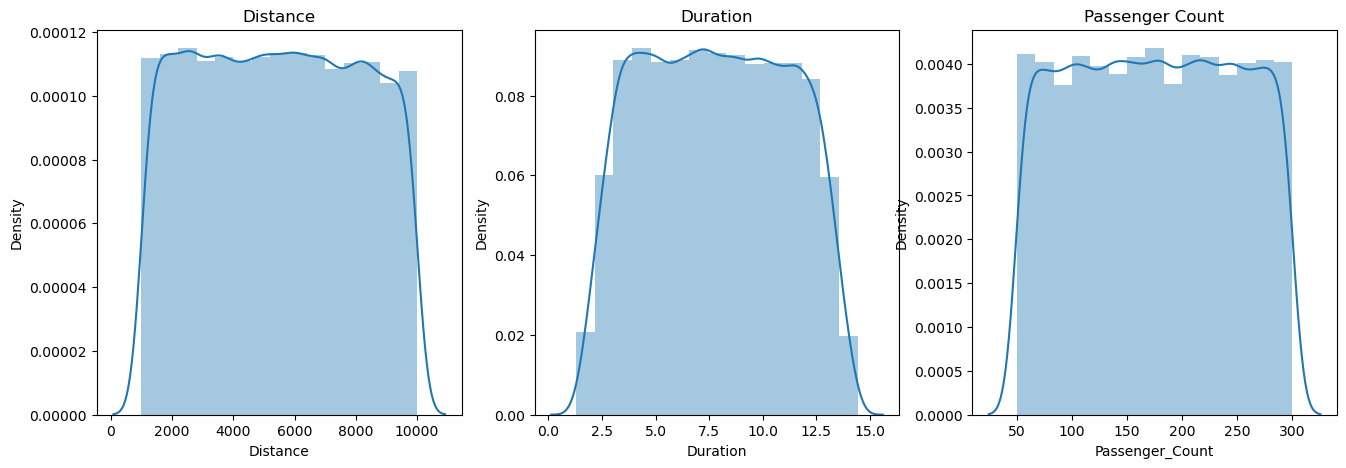

In [22]:
f = plt.figure(figsize=(16,5))

distance= f.add_subplot(131)
distance.set_title('Distance')
sns.distplot(df_v2.Distance, bins = 15,ax=distance);

duration = f.add_subplot(132)
duration.set_title('Duration')
sns.distplot(df_v2.Duration, bins = 15,ax=duration);

pas_count = f.add_subplot(133)
pas_count.set_title('Passenger Count')
sns.distplot(df_v2.Passenger_Count, bins = 15,ax=pas_count);


we can use this distribution to create new feature, which are more useful for prediction making 

### **Bivariate Analysis**

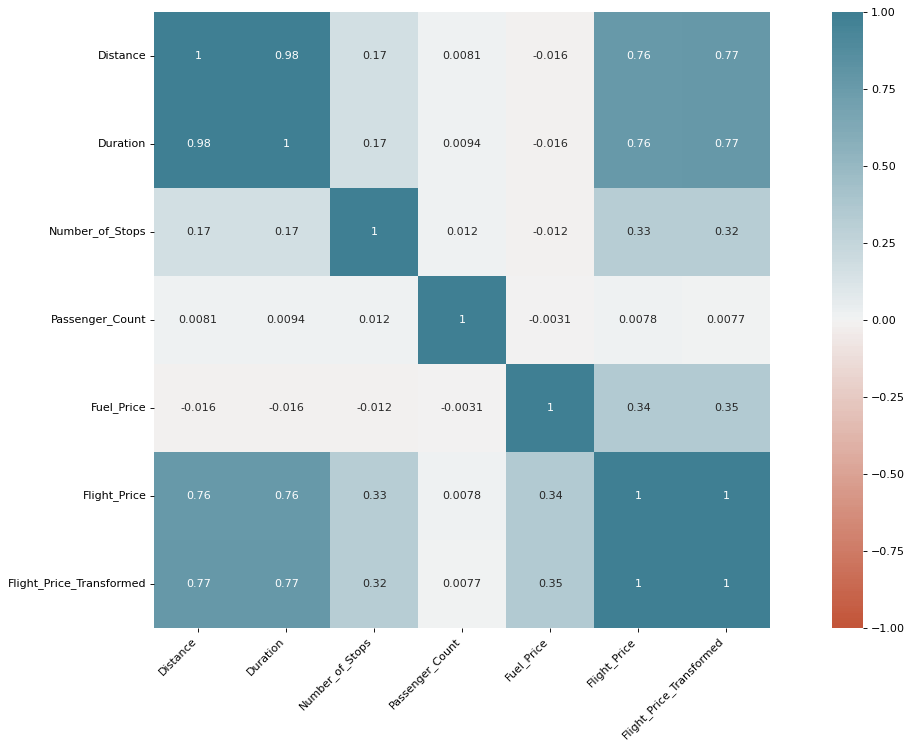

In [23]:
corr1=df_v2[Numerical_columns].corr()
plt.figure(figsize=(20, 10), dpi=80)
ax = sns.heatmap(
    corr1,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
); # use xticklabels to rotate la

to note:
- the columns "Passenger_Count" doesn't correlate much with "Flight_Price" , we can drop it ! 
- Distance and Duration are so much correlated, that we have to drope one of them (multicollinearity)! 

I will also implement [the Chatterjee correlation](https://www.sciencedirect.com/science/article/pii/S0169136822002621), which is capable of identifying linear and nonlinear relationships between variables and is robust against outliers ! 

In [24]:
# chatter je correlation 
#function for finding chatterejee correlation coefficient
def chatterjee_corr(df,x,y):
    # Nr of elements
    N=df.shape[0]
    #create a copy 
    df_rank=df
    # rank of x dependet variable
    df_rank['rank']=df_rank[y].rank()

    # indipendent
    df_rank['rank_x']=df_rank[x].rank()

    #sort the data by rank of independet 
    df_rank=df_rank.sort_values(by='rank_x')
    # calc
    chatt_corr=1 - (3*df_rank['rank'].diff().abs().sum() )/ (pow(N,2)-1)
    return chatt_corr

In [25]:
for col_name in Numerical_columns:
    corr=chatterjee_corr(df_v2,col_name,'Flight_Price')
    print(f'for {col_name} and Flight_Price is the correlations: {corr}')

for Distance and Flight_Price is the correlations: 0.4089568504213892
for Duration and Flight_Price is the correlations: 0.40308911500163336
for Number_of_Stops and Flight_Price is the correlations: 0.06214786562727315
for Passenger_Count and Flight_Price is the correlations: 0.004396730741548671
for Fuel_Price and Flight_Price is the correlations: 0.06177568646899989
for Flight_Price and Flight_Price is the correlations: 0.9999329039184112
for Flight_Price_Transformed and Flight_Price is the correlations: 0.9999329039184112


Okay, the results aren't particularly insightful, so let's proceed to create a baseline model without categorical variables!

## Models without Categorical values
Steps:
- Creating multivariable linear models in from statsmodels and Sklearn and compare them by RMSE!
- Create a polynominal model and compare it's results! 

### Multivariable Linear Regression 

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
# step 1 - Drop "Passenger_Count" and "Distance"
# I'm going with distance, because it's range is bigger than duration ! 
df_v3=df_v2.drop(columns=['Passenger_Count','Distance'])
X=df_v3[['Duration','Number_of_Stops','Fuel_Price']]
y=df_v3[['Flight_Price_Transformed']]
# split the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)
print(f'Shape of Dataset->  Train: {X_train.shape} and Test: {X_test.shape} dataset')

Shape of Dataset->  Train: (38004, 3) and Test: (6707, 3) dataset


### SM-Linear-Model 

In [28]:
X_const=sm.add_constant(X_train)
model_sm=sm.OLS(y_train,X_const).fit()
print(model_sm.summary())

                               OLS Regression Results                               
Dep. Variable:     Flight_Price_Transformed   R-squared:                       0.760
Model:                                  OLS   Adj. R-squared:                  0.760
Method:                       Least Squares   F-statistic:                 4.020e+04
Date:                      Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                              20:20:14   Log-Likelihood:                -71952.
No. Observations:                     38004   AIC:                         1.439e+05
Df Residuals:                         38000   BIC:                         1.439e+05
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [29]:
# test on test dataset 
predictions= model_sm.predict(sm.add_constant(X_test))
loss_sm=np.sqrt(mean_squared_error(y_test,predictions))
print(round(loss_sm,3))

1.626


In [30]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
model_sk_l=LinearRegression()

# Run Cross-Validation
cv_scores = cross_validate( estimator = model_sk_l, X = X_train,y = y_train,
    cv=cv_strategy, 
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    verbose=1,
    n_jobs=3,
)


# Cross Validation Scores
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df

# Average Score
train_cv_score = cv_scores_df["train_score"].mean().round(2)
test_cv_score = cv_scores_df["test_score"].mean().round(2)

print("Train CV Score:", train_cv_score)
print("Test CV Score:", test_cv_score)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Train CV Score: -1.61
Test CV Score: -1.61


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.9s finished


In [31]:
model_sk_l=LinearRegression()
model_sk_l.fit(X_train,y_train)
predictions= model_sk_l.predict(X_test)
loss_sk_l=np.sqrt(mean_squared_error(y_test,predictions))
print(round(loss_sk_l,3))

1.626


In [32]:
# As expectet, they are in the same range of accuracy 

### Polynominal Model 

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=3,include_bias=False)
Xpoly_features=poly.fit_transform(X_train)
model_sk_pl=LinearRegression()
model_sk_pl.fit(Xpoly_features,y_train)
# test
predictions= model_sk_pl.predict(poly.fit_transform(X_test))
loss_sk_pl=np.sqrt(mean_squared_error(y_test,predictions))
print(round(loss_sk_pl,3))

1.605


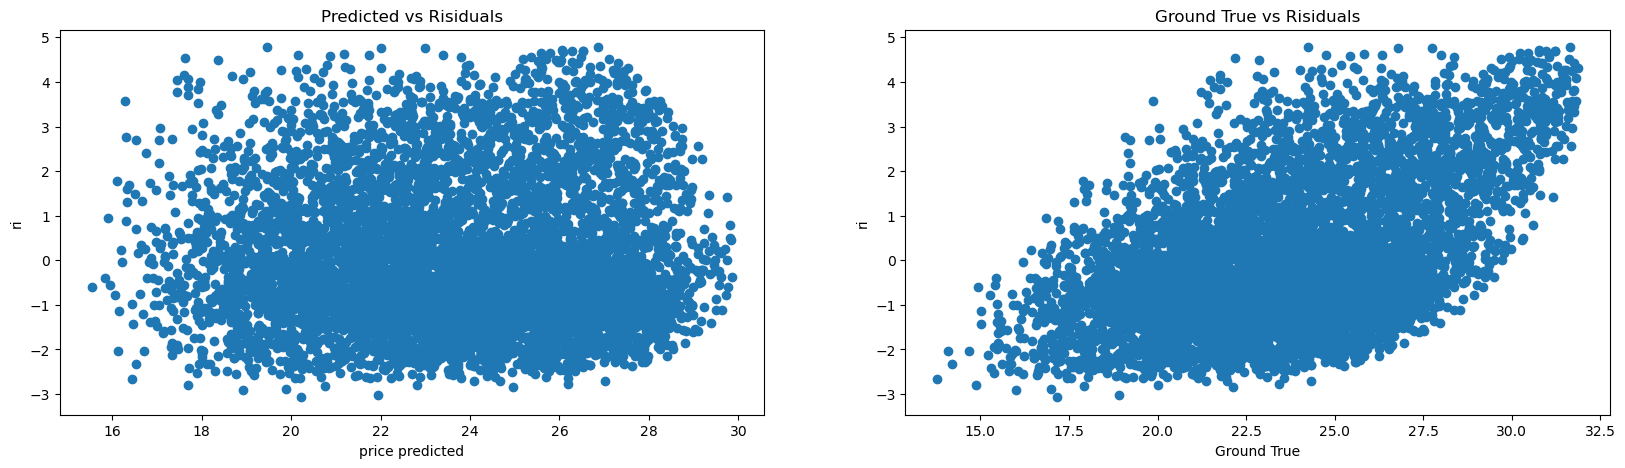

In [38]:
# risiduals vs predictions and 
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
ax.scatter(predictions,(y_test-predictions))
plt.xlabel('price predicted')
plt.ylabel('ri')
plt.title('Predicted vs Risiduals')

# distribution of price in test-dataset
ax2 = f.add_subplot(122)
ax2.scatter(y_test,(y_test-predictions))
plt.xlabel('Ground True')
plt.ylabel('ri')
plt.title('Ground True vs Risiduals')

plt.show()



On the left side, the plots shows ,that the residuals are every where uniforly distributed! </br>
On the left we see a up trending distribution, it could mean, we have some sort of non linearity in out data (non-const-variance in dependet variable) </br>
the Polynominal model performers just a little bit better, lets see, what we get from catergrical ones !</br>

## Exporing categorical Columns

In [138]:
Categorical_columns=df_v1.select_dtypes(include='object').columns
print(Categorical_columns)

Index(['Flight_ID', 'Airline', 'Departure_City', 'Arrival_City',
       'Departure_Time', 'Arrival_Time', 'Aircraft_Type', 'Day_of_Week',
       'Month_of_Travel', 'Holiday_Season', 'Demand', 'Weather_Conditions',
       'Promotion_Type'],
      dtype='object')


There are many column with many unique values , it doesn't make sense to take all of the</br>
Some of them make sense to be in the dataset bacuse of it's nature, like: "Airline" , 'Month_of_Travel', 'Holiday_Season', 'Demand'</br>
'Promotion_Type' , because they have some influence on the Flight_Price

In [146]:
df_v1.Airline.describe()

count         41164
unique            3
top       Airline A
freq          13778
Name: Airline, dtype: object

In [161]:
import scipy.stats as stats
# group the prices by Airlines 
airline_groups=df_v1.groupby("Airline").groups
airline_a= df_v1['Flight_Price_Transformed'][airline_groups['Airline A']]
airline_b= df_v1['Flight_Price_Transformed'][airline_groups['Airline B']]
airline_c= df_v1['Flight_Price_Transformed'][airline_groups['Airline C']]
# one-way anova
stats.f_oneway(airline_a, airline_b, airline_c)

F_onewayResult(statistic=2.7923248686753834, pvalue=0.06129019150121526)

The results of Anova test shows (F-statistic > 0 and p < 0.5 ) , that there are differences between prices , based on the airline and </br>
we can use this variable to predict the Flight prices ! 

In [163]:
#Demand
set(df_v1.Demand)

{'High', 'Low', 'Medium', nan}

In [166]:
demand_groups=df_v1.groupby("Demand").groups
demand_h= df_v1['Flight_Price_Transformed'][demand_groups['High']]
demand_l= df_v1['Flight_Price_Transformed'][demand_groups['Low']]
demand_m= df_v1['Flight_Price_Transformed'][demand_groups['Medium']]
# one-way anova
stats.f_oneway(demand_h, demand_l, demand_m)

F_onewayResult(statistic=4020.72057924547, pvalue=0.0)

The results for "Demand" are more obvoius! 